In [1]:
import torch
from math import pi
from torch import nn
import seaborn as sns
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
def data(batch_size, seq_len):
    return ((torch.randn(batch_size, seq_len)+torch.arange(seq_len, dtype=torch.float))/(2*pi)).sin()

In [3]:
class Flow(nn.Module):
    def __init__(self, seq_len, hidden, flip):
        super().__init__()
        half_seq_len = seq_len // 2
        self.log_s = nn.Sequential(
            nn.Linear(half_seq_len, hidden),
            nn.ReLU(True),
            nn.Linear(hidden, half_seq_len)
        )
        self.b = nn.Sequential(
            nn.Linear(half_seq_len, hidden),
            nn.ReLU(True),
            nn.Linear(hidden, half_seq_len)
        )
        self.flip = flip
    
    def forward(self, z):
        za, zb = z.chunk(2, dim=1)
        if self.flip:
            za, zb = zb, za
            
        log_s, b = self.log_s(za), self.b(za)
        ya = za
        yb = (zb - b) / log_s.exp()
        
        if self.flip:
            ya, yb = yb, ya
        y = torch.cat((ya, yb), dim=1)
        return y
    
    def reverse(self, y):
        ya, yb = y.chunk(2, dim=1)
        if self.flip:
            ya, yb = yb, ya

        log_s, b = self.log_s(ya), self.b(ya)
        za = ya
        zb = yb*log_s.exp() + b
        
        if self.flip:
            za, zb = zb, za
        z = torch.cat((za, zb), dim=1)
        return z, log_s

class Model(nn.Module):
    def __init__(self, d, hidden, num_flows):
        super().__init__()
        self.flows = nn.ModuleList([
            Flow(d, hidden, i%2==0)
            for i in range(num_flows)
        ])
        self.distribution = torch.distributions.MultivariateNormal(torch.zeros(d), torch.eye(d))
    
    def forward(self, batch_size):
        y = self.distribution.rsample(sample_shape=(batch_size,))
        for flow in self.flows:
            y = flow(y)
        return y
    
    def reverse(self, y):
        """This is used for training in this system"""
        z = y
        log_jacob = 0
        for flow in reversed(self.flows):
            z, ls = flow.reverse(z)
            log_jacob += ls.sum(-1)
        log_pz = self.distribution.log_prob(z)
        return z, log_pz, log_jacob

step 0000:: 161.21478271484375
step 0009:: 96.89705657958984
step 0018:: 39.259315490722656
step 0027:: -11.177682876586914
step 0036:: -50.630821228027344
step 0045:: -73.70146942138672
step 0054:: -80.73790740966797
step 0063:: -90.85005187988281
step 0072:: -96.81282043457031
step 0081:: -102.36935424804688
step 0090:: -104.28153991699219
step 0099:: -108.26100158691406



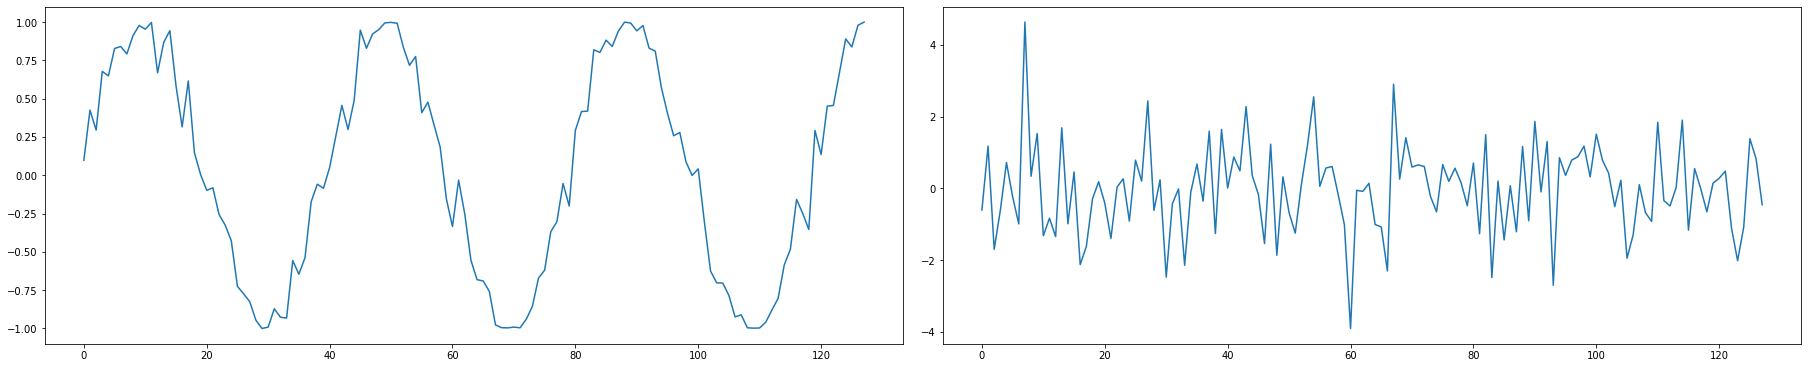

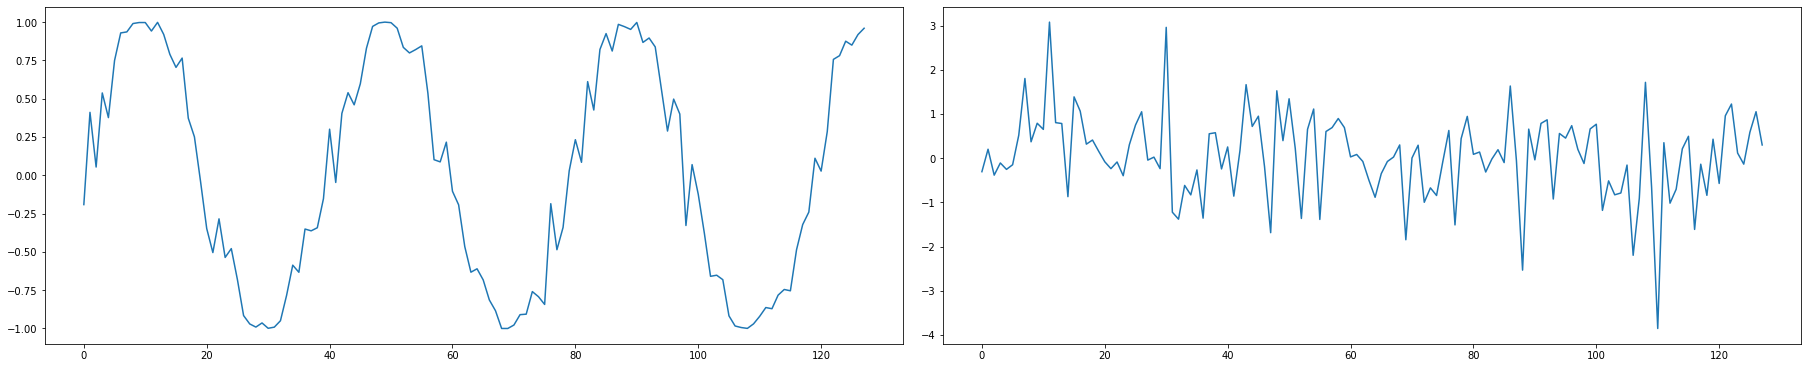

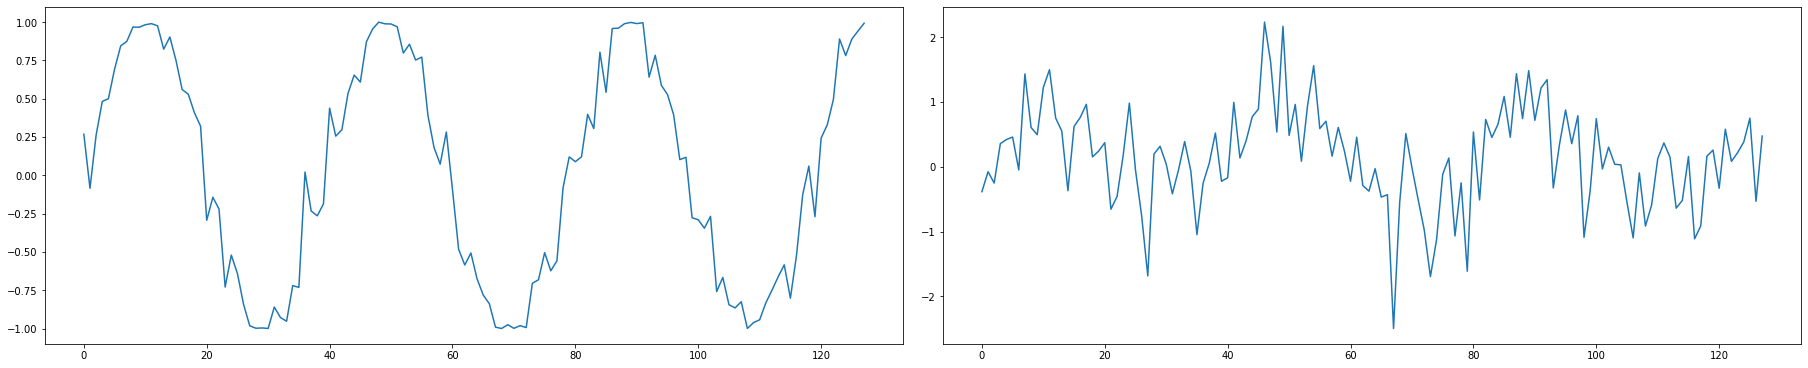

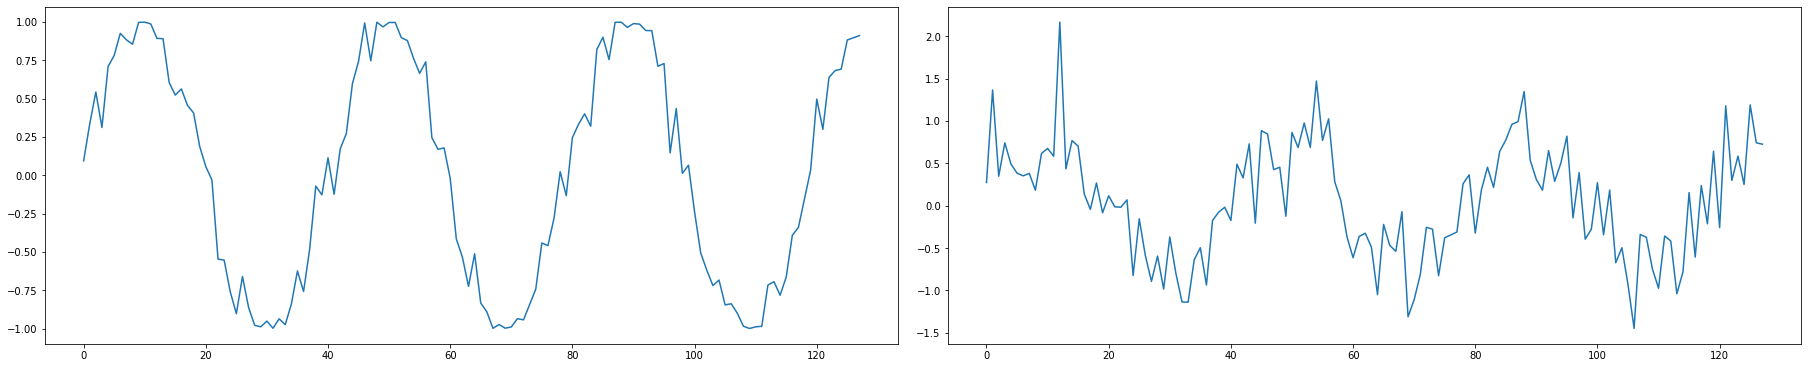

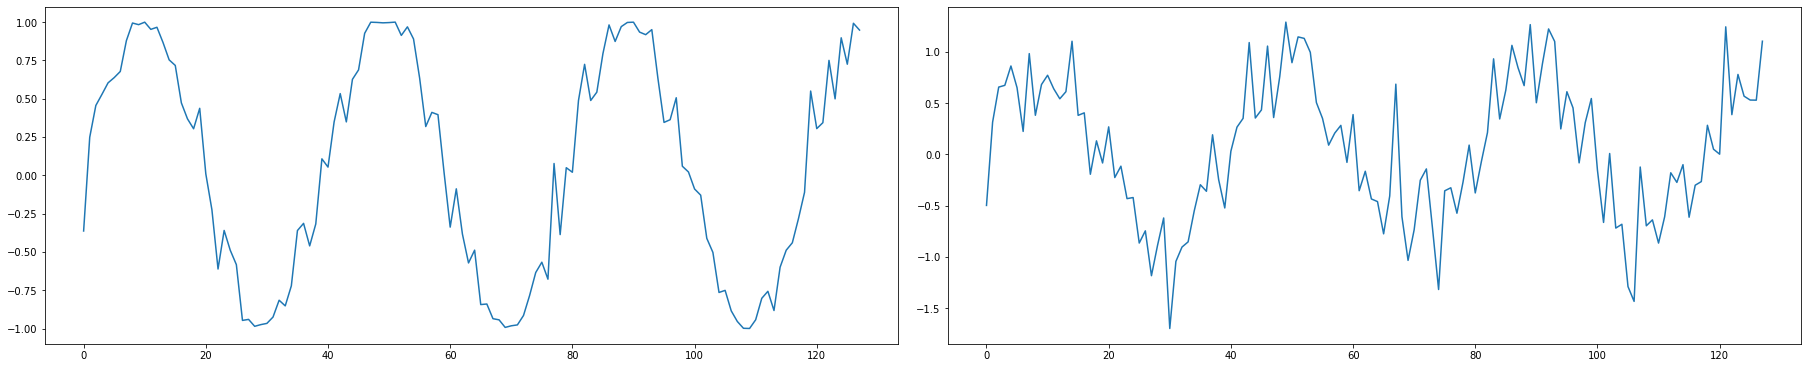

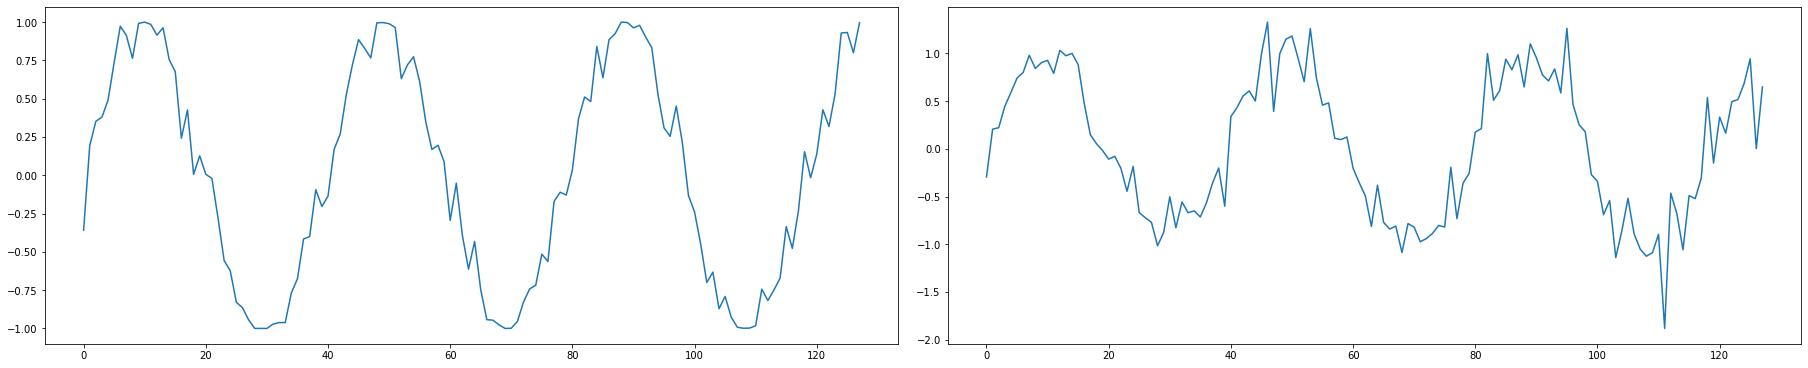

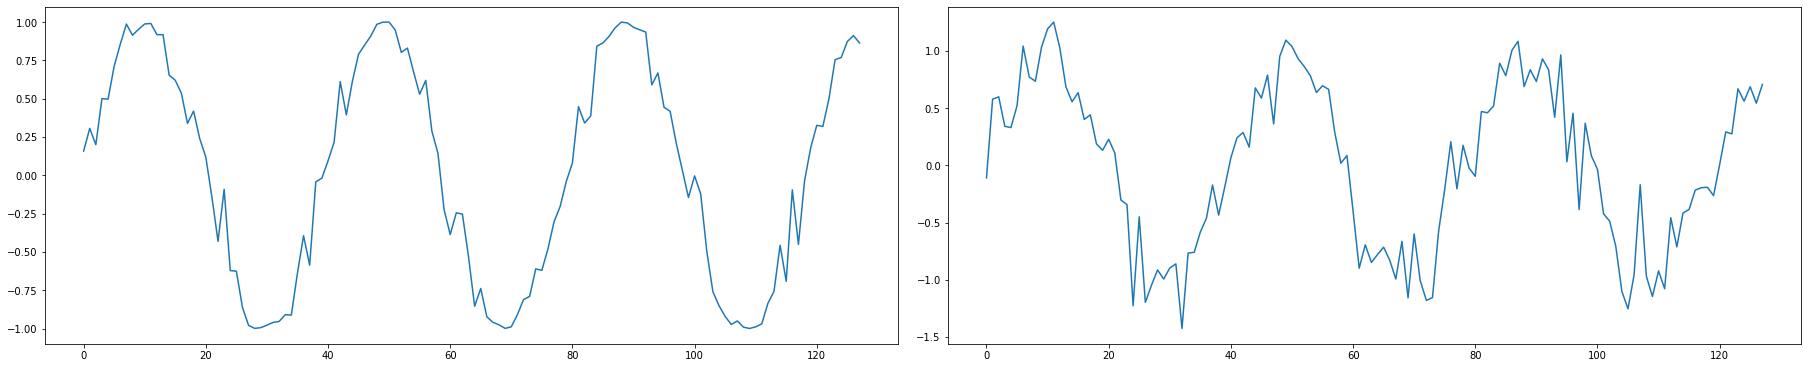

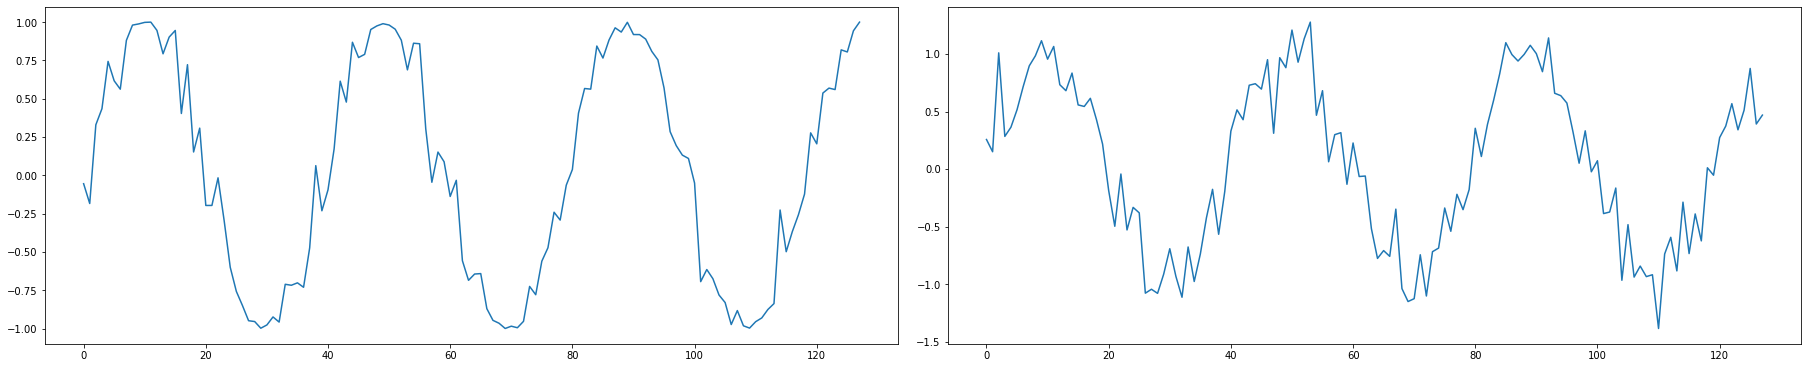

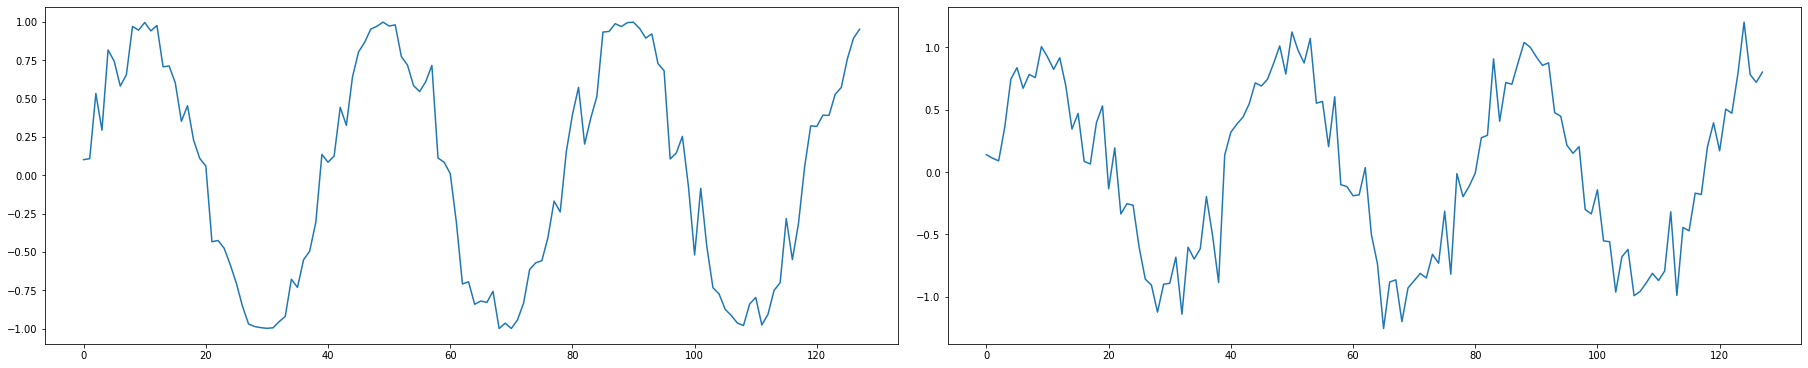

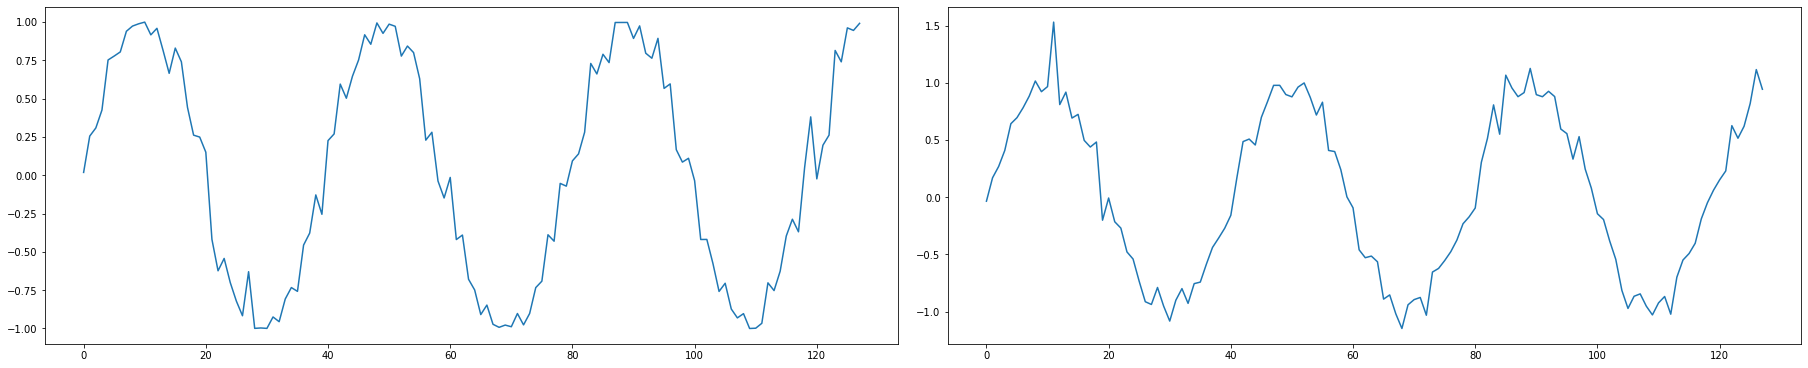

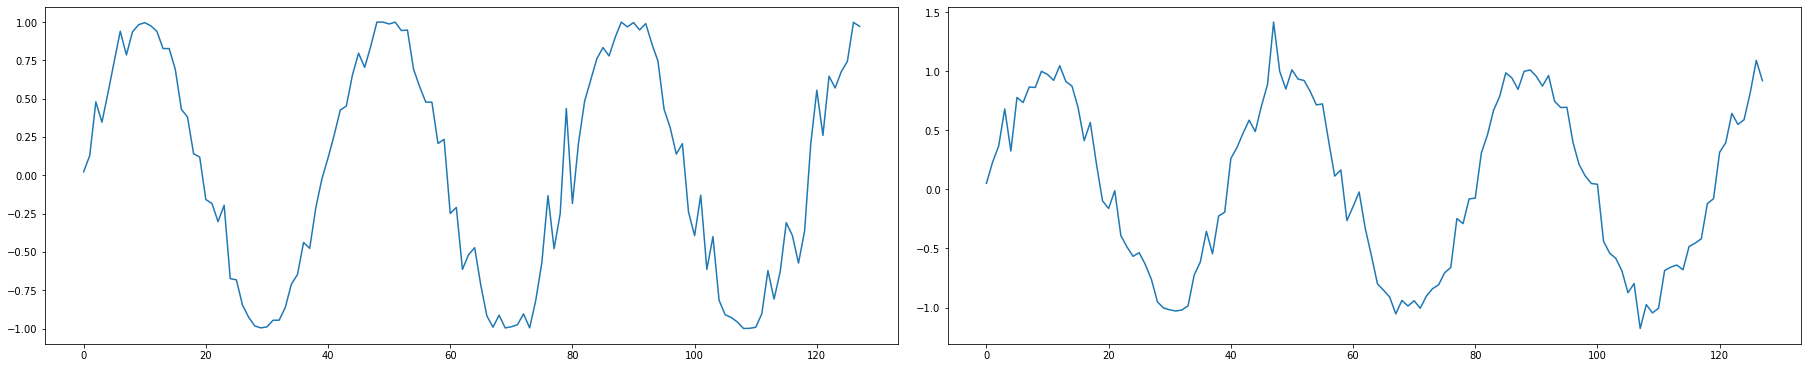

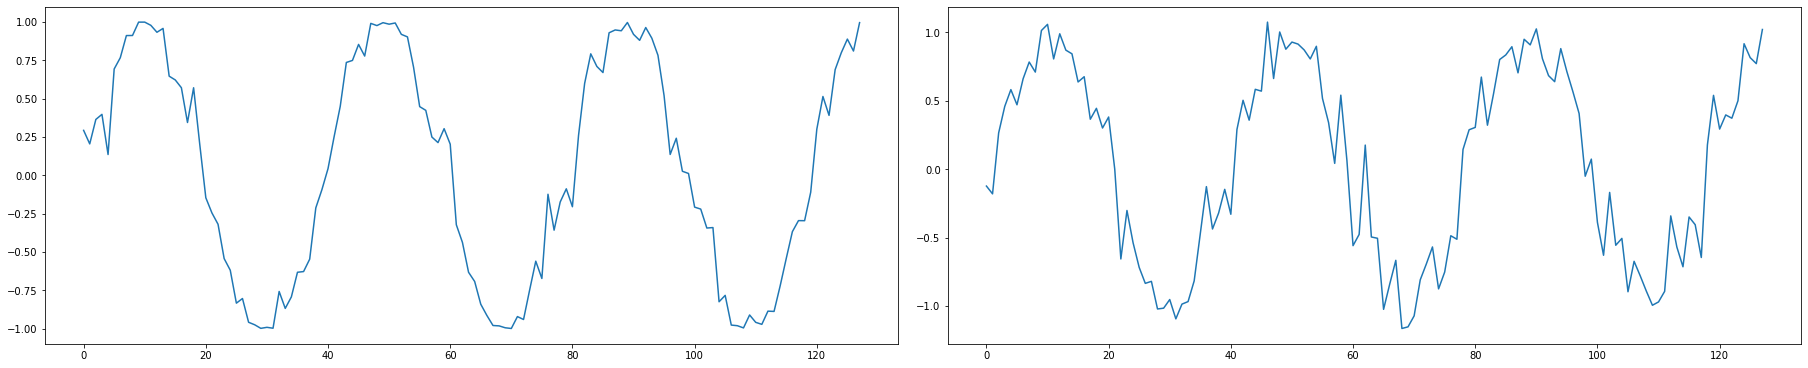

In [4]:
num_flows = 5
seq_len = 128
batch_size = 512
epochs = 100
display_div = 9

model = Model(seq_len, 1024, num_flows)
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

for step in tqdm(range(epochs), "Fitting"):
    optim.zero_grad()
    y = data(batch_size, seq_len)
    z, log_pz, log_jacob = model.reverse(y)
    loss = (-log_pz - log_jacob).mean()
    loss.backward()
    optim.step()
    
    with torch.no_grad():
        if step % display_div == 0:
            print(f"step {step:04d}:: {loss.item()}")
            y2 = model.forward(1)
            y = data(1, seq_len)
            fig, ax = plt.subplots(1,2, figsize=(25,5), constrained_layout=True)
            ax[0].plot(y[0])
            ax[1].plot(y2[0])
            fig.show()